In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##Machine Learning:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report,accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, auc

In [2]:
#Lendo todo o banco de dados:
dfClientes = pd.read_excel('caso_estudo.xlsx', sheet_name = 'clientes')
dfLojas = pd.read_excel('caso_estudo.xlsx', sheet_name = 'lojas')
dfPagamentos = pd.read_excel('caso_estudo.xlsx', sheet_name = 'pagamentos')
dfProdutos = pd.read_excel('caso_estudo.xlsx', sheet_name = 'produtos')
dfVendas = pd.read_excel('caso_estudo.xlsx', sheet_name = 'vendas')
dfPromocao = pd.read_csv('caso_estudo_venda_promocao.csv', sep=";")

In [3]:
#Inserindo todos os dados da Aula12:
#Esse caso está substituindo os valores nulos por informações que são possíveis de rastrear depois:
dfClientes.loc[dfClientes.nome.isnull(),'nome'] = 'Sem Nome'
dfClientes.loc[dfClientes.sexo.isnull(),'sexo'] = 'O'
dfClientes.loc[dfClientes.dt_nasc.isnull(),'dt_nasc'] = '01/01/2020'

#Formato das datas:
dfClientes.dt_nasc = pd.to_datetime(dfClientes.dt_nasc, format = '%m/%d/%Y')

#Manipulando um valor específico de um produto, feito na Aula11:
#Manipulando o valor do produto 'xxx-231a' para chegar em um valor real:
dfProdutos.loc[9, 'valor'] = dfProdutos.valor[9]/10000
dfProdutos
#Indexes feitos na Aula11:
dfClientes = dfClientes.set_index('id')
dfLojas = dfLojas.set_index('id')
dfProdutos = dfProdutos.set_index('id')
dfVendas = dfVendas.set_index('id')
dfPagamentos = dfPagamentos.set_index('id')
dfPromocao = dfPromocao.set_index('id_venda')

#Joins feitos na Aula12:
df = dfVendas.join(dfClientes.add_prefix('cliente_'), on = 'id_cliente')
df = df.join(dfLojas.add_prefix('loja_'), on = 'id_loja')
df = df.join(dfProdutos.add_prefix('produto_'), on = 'id_produto')
df = df.join(dfPagamentos.set_index('id_venda'))
df = df.join(dfPromocao)

#Inserindo Colunas feitas na Aula13:
#Inserindo uma coluna para quando ouve algum pagamento, caso a data do pagamento('dt_pgto') for nula('NaT') será representada como 0 para não feita:
df['pg'] = 1
df.loc[df.dt_pgto.isnull(), 'pg'] = 0
#Inserindo mais uma coluna: Tempo de pagamento em dias:
df['tempo_pg'] = (df.dt_pgto - df.dt_venda).dt.days
#Inserindo a coluna 'idade':
df['cliente_idade'] = np.floor((pd.to_datetime('today').normalize() - pd.to_datetime(df['cliente_dt_nasc'])).dt.days / 365.25)

#Dando print:
df

,id_cliente,id_loja,id_produto,dt_venda,cliente_nome,cliente_sexo,cliente_dt_nasc,loja_cidade,produto_produto,produto_valor,dt_pgto,promoção,pg,tempo_pg,cliente_idade
id,,,,,,,,,,,,,,,
1,393,9,3,2018-01-04,Gustavo Silva,M,1950-01-04,Palmas,laptop básico,2300.0,2018-01-24,0,1,20.0,74.0
2,417,9,3,2018-01-04,Leonor Almeida,F,1972-01-31,Palmas,laptop básico,2300.0,2018-02-17,1,1,44.0,52.0
3,374,7,8,2018-01-04,André Alves,M,1962-08-03,Salvador,cadeira,540.0,2018-02-14,1,1,41.0,62.0
4,59,4,3,2018-01-05,Rodrigo Ribeiro,M,1941-11-05,Belo Horizonte,laptop básico,2300.0,NaT,0,0,NaN,82.0
5,18,9,1,2018-01-05,Antônio Azevedo,M,1941-04-15,Palmas,mouse,20.0,2018-01-23,0,1,18.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,671,3,7,2020-09-27,Ana Goncalves,F,1999-10-31,Curitiba,carregador,150.0,2020-10-17,0,1,20.0,24.0
2997,586,8,3,2020-09-27,Aline Pinto,F,1994-03-29,Brasília,laptop básico,2300.0,2020-10-02,0,1,5.0,30.0
2998,731,2,4,2020-09-27,Otávio Silva,M,1986-05-04,Rio de Janeiro,laptop gamer,5300.0,NaT,0,0,NaN,38.0


# Machine Learning
## Alvo

In [5]:
dfML = df[['cliente_sexo','loja_cidade','produto_produto','produto_valor','cliente_idade','promoção','pg']]
dfML = dfML.replace([' ','-'],'-', regex = True)
dfML

,cliente_sexo,loja_cidade,produto_produto,produto_valor,cliente_idade,promoção,pg
id,,,,,,,
1,M,Palmas,laptop-básico,2300.0,74.0,0,1
2,F,Palmas,laptop-básico,2300.0,52.0,1,1
3,M,Salvador,cadeira,540.0,62.0,1,1
4,M,Belo-Horizonte,laptop-básico,2300.0,82.0,0,0
5,M,Palmas,mouse,20.0,83.0,0,1
...,...,...,...,...,...,...,...
2996,F,Curitiba,carregador,150.0,24.0,0,1
2997,F,Brasília,laptop-básico,2300.0,30.0,0,1
2998,M,Rio-de-Janeiro,laptop-gamer,5300.0,38.0,0,0


## Normalização

In [7]:
dfML['produto_valor'] = dfML['produto_valor']/dfML['produto_valor'].max()
dfML['cliente_idade'] = dfML['cliente_idade']/dfML['cliente_idade'].max()
dfML

,cliente_sexo,loja_cidade,produto_produto,produto_valor,cliente_idade,promoção,pg
id,,,,,,,
1,M,Palmas,laptop-básico,0.433962,0.831461,0,1
2,F,Palmas,laptop-básico,0.433962,0.584270,1,1
3,M,Salvador,cadeira,0.101887,0.696629,1,1
4,M,Belo-Horizonte,laptop-básico,0.433962,0.921348,0,0
5,M,Palmas,mouse,0.003774,0.932584,0,1
...,...,...,...,...,...,...,...
2996,F,Curitiba,carregador,0.028302,0.269663,0,1
2997,F,Brasília,laptop-básico,0.433962,0.337079,0,1
2998,M,Rio-de-Janeiro,laptop-gamer,1.000000,0.426966,0,0


## Dados Categóricos

In [9]:
col_cat = ['cliente_sexo','loja_cidade','produto_produto','promoção']
dfML_dummies = pd.get_dummies(dfML[col_cat].astype(str), drop_first=False) #Transformou dados de strign para dados bool, assim facilitando para a interpretação da Ml!
dfML_dummies

,cliente_sexo_F,cliente_sexo_M,cliente_sexo_O,loja_cidade_Belo-Horizonte,loja_cidade_Brasília,loja_cidade_Curitiba,loja_cidade_Palmas,loja_cidade_Recife,loja_cidade_Rio-de-Janeiro,loja_cidade_Salvador,...,produto_produto_impressora,produto_produto_laptop-básico,produto_produto_laptop-gamer,produto_produto_mesa,produto_produto_monitor,produto_produto_mouse,produto_produto_teclado,produto_produto_xxx-231a,promoção_0,promoção_1
id,,,,,,,,,,,,,,,,,,,,,
1,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,True,False
2,True,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,True
3,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
4,False,True,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
5,False,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2997,True,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
2998,False,True,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,False,True,False


In [10]:
dfML = pd.concat([dfML, dfML_dummies], axis=1) 
dfML = dfML.drop(col_cat, axis=1)
dfML

,produto_valor,cliente_idade,pg,cliente_sexo_F,cliente_sexo_M,cliente_sexo_O,loja_cidade_Belo-Horizonte,loja_cidade_Brasília,loja_cidade_Curitiba,loja_cidade_Palmas,...,produto_produto_impressora,produto_produto_laptop-básico,produto_produto_laptop-gamer,produto_produto_mesa,produto_produto_monitor,produto_produto_mouse,produto_produto_teclado,produto_produto_xxx-231a,promoção_0,promoção_1
id,,,,,,,,,,,,,,,,,,,,,
1,0.433962,0.831461,1,False,True,False,False,False,False,True,...,False,True,False,False,False,False,False,False,True,False
2,0.433962,0.584270,1,True,False,False,False,False,False,True,...,False,True,False,False,False,False,False,False,False,True
3,0.101887,0.696629,1,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,0.433962,0.921348,0,False,True,False,True,False,False,False,...,False,True,False,False,False,False,False,False,True,False
5,0.003774,0.932584,1,False,True,False,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,0.028302,0.269663,1,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2997,0.433962,0.337079,1,True,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
2998,1.000000,0.426966,0,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False


## Dados de Treinamento e de Teste

In [12]:
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import roc_auc_score, roc_curve, classification_report,accuracy_score
#from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, auc

y = dfML.pg #Saída, 'pg' é a coluna saída...
X = dfML.drop(['pg'], axis=1) #Entrada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_new = X.loc[[2997,2998]]
X_new

,produto_valor,cliente_idade,cliente_sexo_F,cliente_sexo_M,cliente_sexo_O,loja_cidade_Belo-Horizonte,loja_cidade_Brasília,loja_cidade_Curitiba,loja_cidade_Palmas,loja_cidade_Recife,...,produto_produto_impressora,produto_produto_laptop-básico,produto_produto_laptop-gamer,produto_produto_mesa,produto_produto_monitor,produto_produto_mouse,produto_produto_teclado,produto_produto_xxx-231a,promoção_0,promoção_1
id,,,,,,,,,,,,,,,,,,,,,
2997,0.433962,0.337079,True,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,True,False
2998,1.000000,0.426966,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False


## Regressão Logística

In [14]:
#Bibliotecas para criar os mdelos:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression

all_col_with_plus = ' + '.join(dfML.drop(['pg'], axis=1).columns)
modelo = smf.glm(formula='pg ~ ' + all_col_with_plus, data=dfML,
                family = sm.families.Binomial()).fit()
print(modelo.summary())

PatsyError: Error evaluating factor: NameError: name 'loja_cidade_Belo' is not defined
    pg ~ produto_valor + cliente_idade + cliente_sexo_F + cliente_sexo_M + cliente_sexo_O + loja_cidade_Belo-Horizonte + loja_cidade_Brasília + loja_cidade_Curitiba + loja_cidade_Palmas + loja_cidade_Recife + loja_cidade_Rio-de-Janeiro + loja_cidade_Salvador + loja_cidade_Santa-Catarina + loja_cidade_São-Paulo + loja_cidade_Vitória + produto_produto_cadeira + produto_produto_carregador + produto_produto_impressora + produto_produto_laptop-básico + produto_produto_laptop-gamer + produto_produto_mesa + produto_produto_monitor + produto_produto_mouse + produto_produto_teclado + produto_produto_xxx-231a + promoção_0 + promoção_1
                                                                                            ^^^^^^^^^^^^^^^^

In [ ]:
model = LogisticRegression(penalty='none', solver='newton-cg')
model.fit(X_train, y_train)

print('- Matriz de Confusão')
print(confusion_matrix(y_test, model.predict(X_test)))
print('\n- Reporte completo')
print(classification_report(y, model.predict(X)))
print('\n- Reporte teste')
print(classification_report(y_test, model.predict(X_test)))

In [ ]:
model.predict(X_new)

## Árvore de Decisão

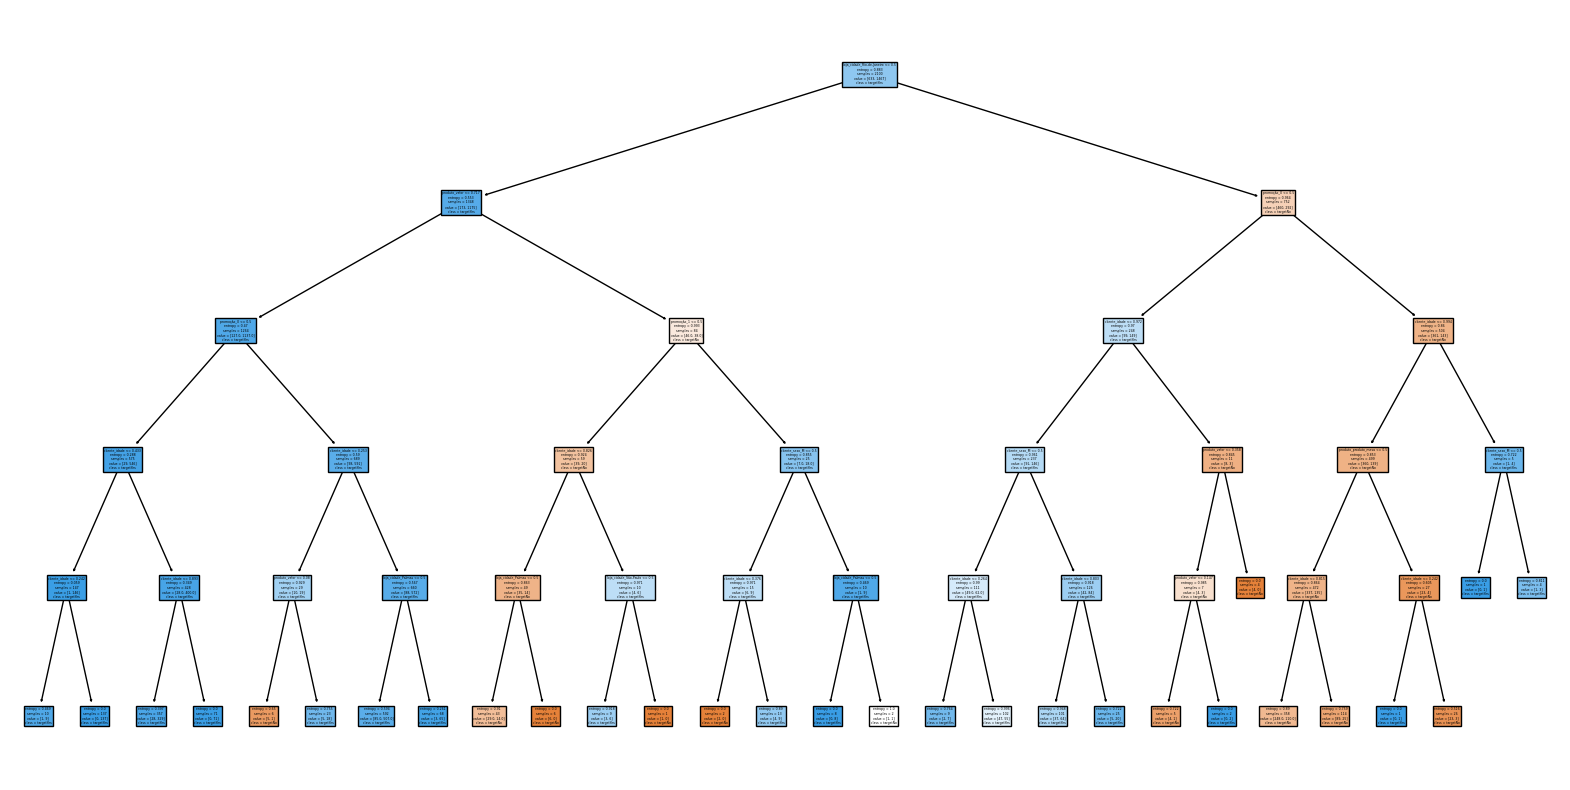

In [15]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics, tree

model = DecisionTreeClassifier(criterion="entropy", max_depth=5)
model = model.fit(X_train,y_train)
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(model, 
                   feature_names=X.columns,  
                   class_names=['targetNo','targetYes'],
                   filled=True)

In [17]:
print('- Matriz de Confusão')
print(confusion_matrix(y_test, model.predict(X_test)))
print('\n- Reporte completo')
print(classification_report(y, model.predict(X)))
print('\n- Reporte teste')
print(classification_report(y_test, model.predict(X_test)))

- Matriz de Confusão
[[185 110]
 [ 83 522]]

- Reporte completo
              precision    recall  f1-score   support

           0       0.71      0.64      0.68       928
           1       0.85      0.89      0.87      2072

    accuracy                           0.81      3000
   macro avg       0.78      0.76      0.77      3000
weighted avg       0.81      0.81      0.81      3000


- Reporte teste
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       295
           1       0.83      0.86      0.84       605

    accuracy                           0.79       900
   macro avg       0.76      0.74      0.75       900
weighted avg       0.78      0.79      0.78       900



In [20]:
model.predict(X_new)

array([1, 0], dtype=int64)

## Redes Neurais

In [22]:
from keras import Sequential
from keras.layers import Dense
import keras
import tensorflow
tensorflow.random.set_seed(2)

model = Sequential()
model.add(Dense(15, activation='relu', kernel_initializer='random_normal', input_dim=len(X.columns)))
model.add(Dense(7, activation='relu', kernel_initializer='random_normal'))
model.add(Dense(3, activation='relu', kernel_initializer='random_normal'))
model.add(Dense(3, activation='relu', kernel_initializer='random_normal'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

ModuleNotFoundError: No module named 'keras'

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train,y_train, batch_size=128, epochs=300, verbose=False)

AttributeError: 'DecisionTreeClassifier' object has no attribute 'compile'

In [26]:
print('- Matriz de Confusão')
print(confusion_matrix(y_test, model.predict_classes(X_test)))
print('\n- Reporte completo')
print(classification_report(y, model.predict_classes(X)))
print('\n- Reporte teste')
print(classification_report(y_test, model.predict_classes(X_test)))

- Matriz de Confusão


AttributeError: 'DecisionTreeClassifier' object has no attribute 'predict_classes'

In [28]:
model.predict(X_new)

array([1, 0], dtype=int64)

## XGBoost

In [30]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

ModuleNotFoundError: No module named 'xgboost'

In [32]:
print('- Matriz de Confusão')
print(confusion_matrix(y_test, model.predict(X_test)))
print('\n- Reporte completo')
print(classification_report(y, model.predict(X)))
print('\n- Reporte teste')
print(classification_report(y_test, model.predict(X_test)))

- Matriz de Confusão
[[185 110]
 [ 83 522]]

- Reporte completo
              precision    recall  f1-score   support

           0       0.71      0.64      0.68       928
           1       0.85      0.89      0.87      2072

    accuracy                           0.81      3000
   macro avg       0.78      0.76      0.77      3000
weighted avg       0.81      0.81      0.81      3000


- Reporte teste
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       295
           1       0.83      0.86      0.84       605

    accuracy                           0.79       900
   macro avg       0.76      0.74      0.75       900
weighted avg       0.78      0.79      0.78       900



In [34]:
model.predict(X_new)

array([1, 0], dtype=int64)